# Anime Recommendation

This notebook analysed Japanese anime data and create a recommendation model using 2 approaches, which are Content-based Approach and Collaborative Filtering Approach (Matrix Factorization).

The dataset was downloaded from Kaggle, and created originally by HERNAN VALDIVIESO. This dataset contains information about 17,562 anime and the preference from 325,772 different users. It can be access in this file through path `./dataset/`. 

- `anime.csv` : information of anime
- `anime_with_synopsis.csv`: synopsis of anime
- `animelist.csv`: the list of anime registered by users
- `rating_complete.csv`: the list of rating given by users where `watching_status==2`
- `watching_status.csv`: the description of possible watching status made by users

[Dataset Link](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020)

## Dependencies

Import all required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import re

print("Numpy version - ", np.__version__)
print("Pandas version - ", pd.__version__)
print("Matplotlib version - ", mpl.__version__)

Numpy version -  1.26.0
Pandas version -  2.2.2
Matplotlib version -  3.7.2


In [2]:
# Load files
file_path = './dataset/'
files = {}
for file in os.listdir(file_path):
    if os.path.isfile(os.path.join(file_path, file)) and file != '.DS_Store':
        f = file.split('.')[0]
        files[f] = file
        print(f)

animelist
anime
watching_status
rating_complete
anime_with_synopsis


## Data Cleaning

This module contains the part reading csv files, and cleaning the NULL data.

### Anime

In [3]:
# anime.csv
anime_df = pd.read_csv(os.path.join(file_path, files['anime']))
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [5]:
anime_df.isnull().sum()

MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [6]:
anime_df['Score'] = anime_df['Score'].replace('Unknown', '0.00')
anime_df['Score'] = anime_df['Score'].astype(float)

In [7]:
for i in range(1, 11):
    col = 'Score-' + str(i)
    anime_df[col] = pd.to_numeric(anime_df[col], errors='coerce')
    anime_df[col] = anime_df[col].fillna(0).round().astype(int)

In [8]:
anime_df['Episodes'] = anime_df['Episodes'].replace('Unknown', '-1').astype(int)

anime_df['Ranked'] = pd.to_numeric(anime_df['Ranked'], errors='coerce')
anime_df['Ranked'] = anime_df['Ranked'].fillna(-1).round().astype(int)

In [9]:
def split_date(aired_date):
    date = re.findall(r'\b[A-Za-z]{3} \d{1,2}, \d{4}\b', aired_date)
    if len(date) == 2:
        return date[0], date[1]
    elif len(date) == 1:
        return date[0], None
    else:
        return None, None

anime_df[['Start date', 'End date']] = anime_df['Aired'].apply(split_date).apply(pd.Series)
anime_df = anime_df.drop('Aired', axis=1)

In [10]:
anime_df = anime_df.sort_values(by='MAL_ID')
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Premiered,Producers,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Start date,End date
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,Spring 1998,Bandai Visual,...,131625,62330,20688,8904,3184,1357,741,1580,"Apr 3, 1998","Apr 24, 1999"
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,Unknown,"Sunrise, Bandai Visual",...,49505,22632,5805,1877,577,221,109,379,"Sep 1, 2001",None
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,Spring 1998,Victor Entertainment,...,86142,49432,15376,5838,1965,664,316,533,"Apr 1, 1998","Sep 30, 1998"
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",...,10128,11618,5709,2920,1083,353,164,131,"Jul 2, 2002","Dec 24, 2002"
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,Fall 2004,"TV Tokyo, Dentsu",...,1242,1713,1068,634,265,83,50,27,"Sep 30, 2004","Sep 29, 2005"


In [11]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MAL_ID         17562 non-null  int64  
 1   Name           17562 non-null  object 
 2   Score          17562 non-null  float64
 3   Genres         17562 non-null  object 
 4   English name   17562 non-null  object 
 5   Japanese name  17562 non-null  object 
 6   Type           17562 non-null  object 
 7   Episodes       17562 non-null  int64  
 8   Premiered      17562 non-null  object 
 9   Producers      17562 non-null  object 
 10  Licensors      17562 non-null  object 
 11  Studios        17562 non-null  object 
 12  Source         17562 non-null  object 
 13  Duration       17562 non-null  object 
 14  Rating         17562 non-null  object 
 15  Ranked         17562 non-null  int64  
 16  Popularity     17562 non-null  int64  
 17  Members        17562 non-null  int64  
 18  Favori

### User-Anime List

In [12]:
# animelist.csv
animelist_df = pd.read_csv(os.path.join(file_path, files['animelist']))
animelist_df.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [13]:
animelist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 4.1 GB


In [14]:
animelist_df.isnull().sum()

user_id             0
anime_id            0
rating              0
watching_status     0
watched_episodes    0
dtype: int64

### Rating Complete

In [15]:
# rating_complete.csv
rating_complete_df = pd.read_csv(os.path.join(file_path, files['rating_complete']))
rating_complete_df.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [16]:
rating_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


In [17]:
rating_complete_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Anime with Synopsis

In [18]:
# anime_with_synopsis.csv
synopsis_df = pd.read_csv(os.path.join(file_path, files['anime_with_synopsis']))
synopsis_df.head()

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [19]:
synopsis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genres     16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


In [20]:
synopsis_df.isnull().sum()

MAL_ID       0
Name         0
Score        0
Genres       0
sypnopsis    8
dtype: int64

In [21]:
synopsis_df.fillna('', inplace=True)
synopsis_df.isnull().sum()

MAL_ID       0
Name         0
Score        0
Genres       0
sypnopsis    0
dtype: int64

### Watching Status

In [22]:
# watching_status.csv
watching_status = pd.read_csv(os.path.join(file_path, files['watching_status']))
watching_status

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


## Data Visualization

In [20]:
df_copy = anime_df.copy()

In [50]:
df_copy = df_copy.sort_values(by='Score', ascending=False)
df_copy[['MAL_ID', 'Name', 'Score']].head(10)

,MAL_ID,Name,Score
3971,5114,Fullmetal Alchemist: Brotherhood,9.19
5683,9253,Steins;Gate,9.11
6474,11061,Hunter x Hunter (2011),9.10
11308,32281,Kimi no Na wa.,8.96
1431,1575,Code Geass: Hangyaku no Lelouch,8.72
1393,1535,Death Note,8.63
11,21,One Piece,8.52
7449,16498,Shingeki no Kyojin,8.48
20,30,Neon Genesis Evangelion,8.32
1574,1735,Naruto: Shippuuden,8.16


In [52]:
df_copy = df_copy[df_copy['Popularity'] != 0].sort_values(by='Popularity', ascending=True)
df_copy[['MAL_ID', 'Name', 'Popularity']].head(10)

,MAL_ID,Name,Popularity
1393,1535,Death Note,1
7449,16498,Shingeki no Kyojin,2
3971,5114,Fullmetal Alchemist: Brotherhood,3
5683,9253,Steins;Gate,9
11308,32281,Kimi no Na wa.,11
6474,11061,Hunter x Hunter (2011),12
1431,1575,Code Geass: Hangyaku no Lelouch,15
1574,1735,Naruto: Shippuuden,18
11,21,One Piece,31
20,30,Neon Genesis Evangelion,54


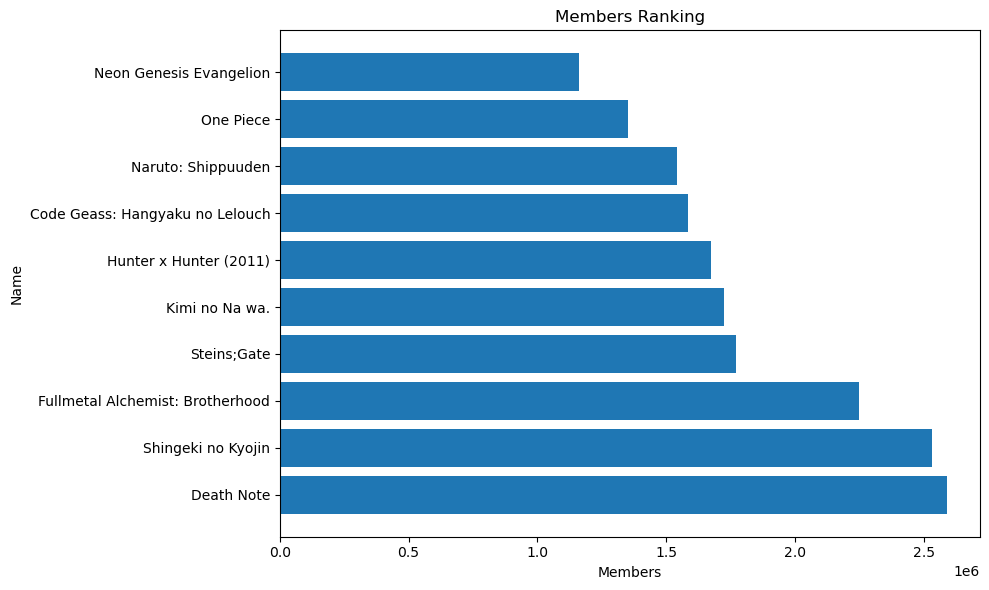

In [47]:
df_copy = df_copy.sort_values(by='Members', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(df_copy['Name'], df_copy['Members'])
plt.title('Members Ranking')
plt.xlabel('Members')
plt.ylabel('Name')
plt.tight_layout()
plt.show()

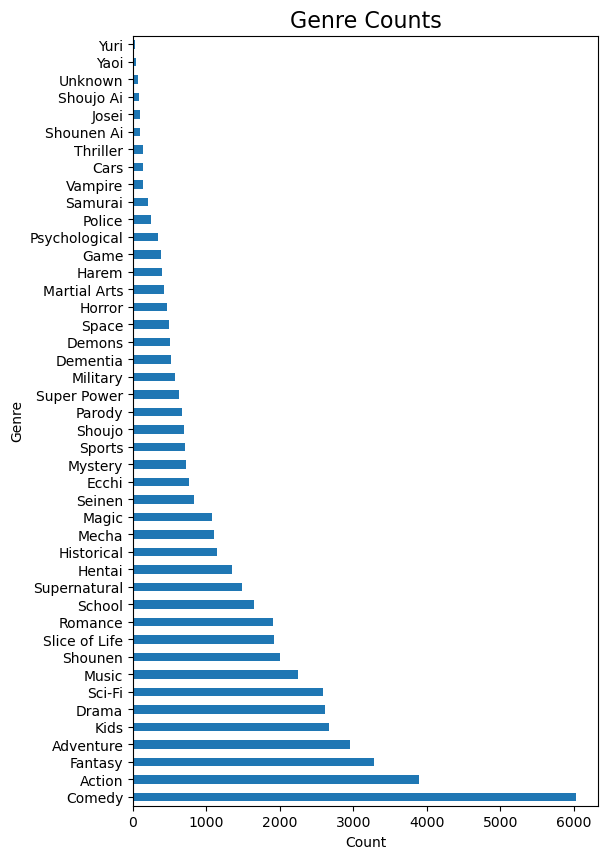

In [34]:
all_genres = anime_df['Genres'].str.split(', ').explode()
genre_counts = all_genres.value_counts()

plt.figure(figsize=(6, 10))
genre_counts.plot(kind='barh')

plt.title('Genre Counts', fontsize=16)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Genre', fontsize=10)
plt.show()

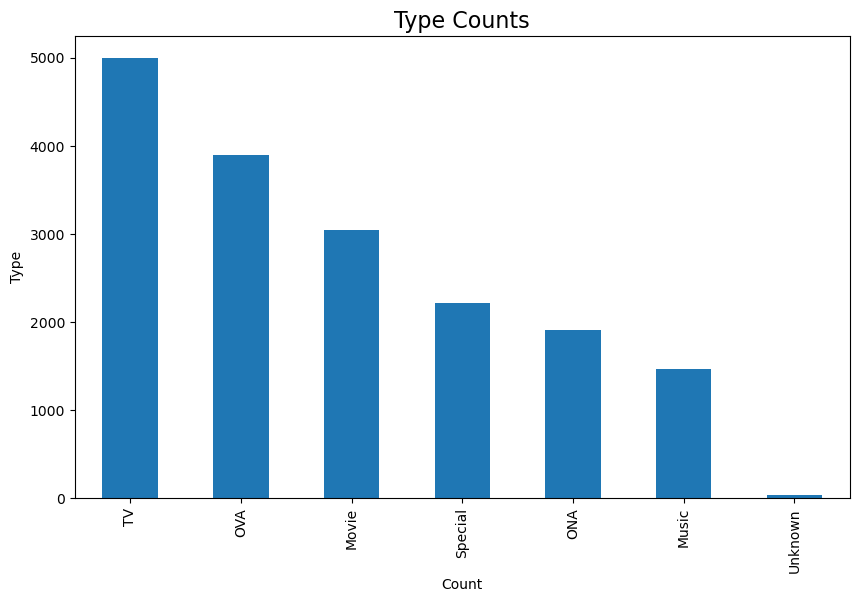

In [49]:
type_counts = anime_df['Type'].value_counts()

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')

plt.title('Type Counts', fontsize=16)
plt.xlabel('Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

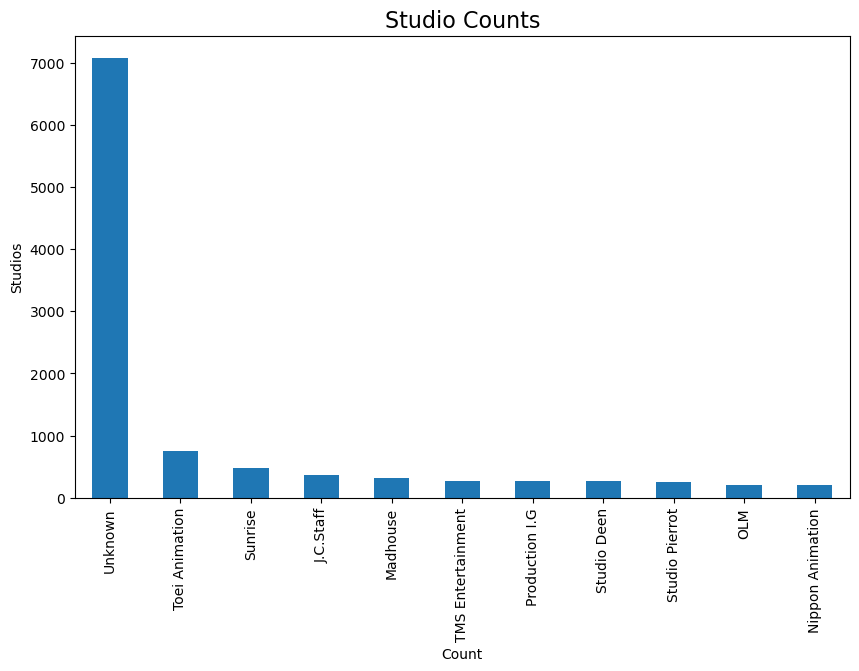

In [59]:
studio_counts = anime_df['Studios'].value_counts().head(11)

plt.figure(figsize=(10, 6))
studio_counts.plot(kind='bar')

plt.title('Studio Counts', fontsize=16)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Studios', fontsize=10)
plt.show()

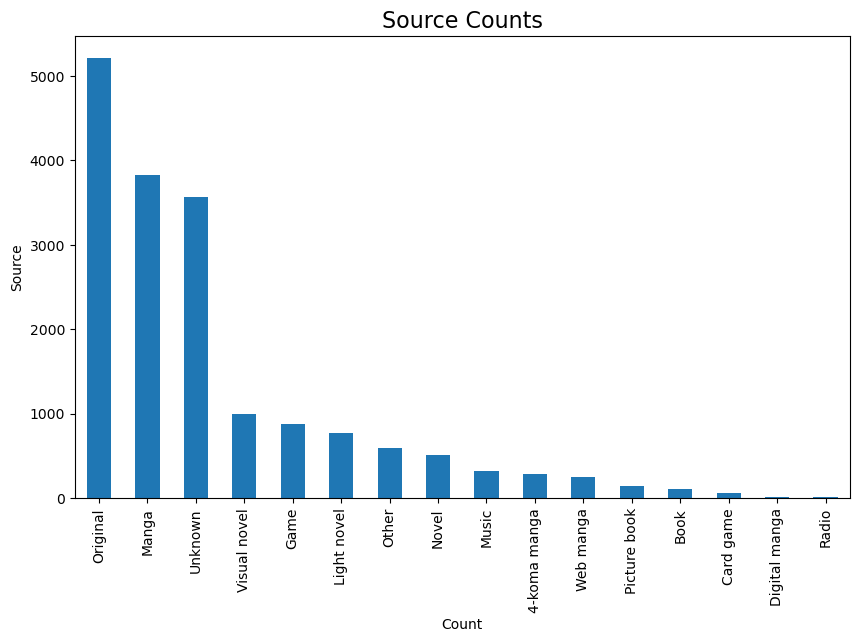

In [56]:
source_counts = anime_df['Source'].value_counts()

plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar')

plt.title('Source Counts', fontsize=16)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Source', fontsize=10)
plt.show()

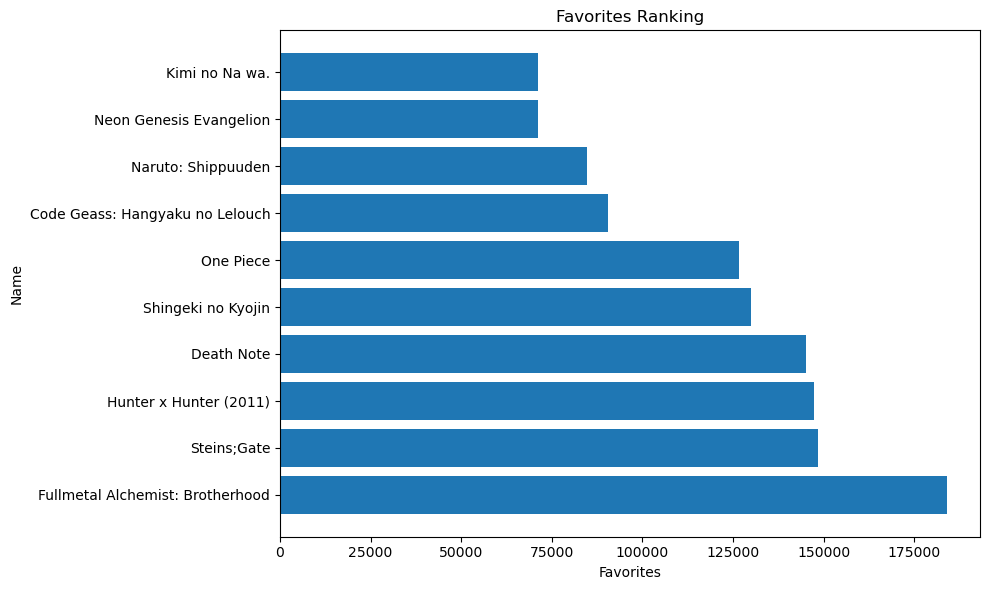

In [23]:
df_copy = df_copy.sort_values(by='Favorites', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh((df_copy['Name']), df_copy['Favorites'])

plt.title('Favorites Ranking')
plt.xlabel('Favorites')
plt.ylabel('Name')
plt.tight_layout()
plt.show()

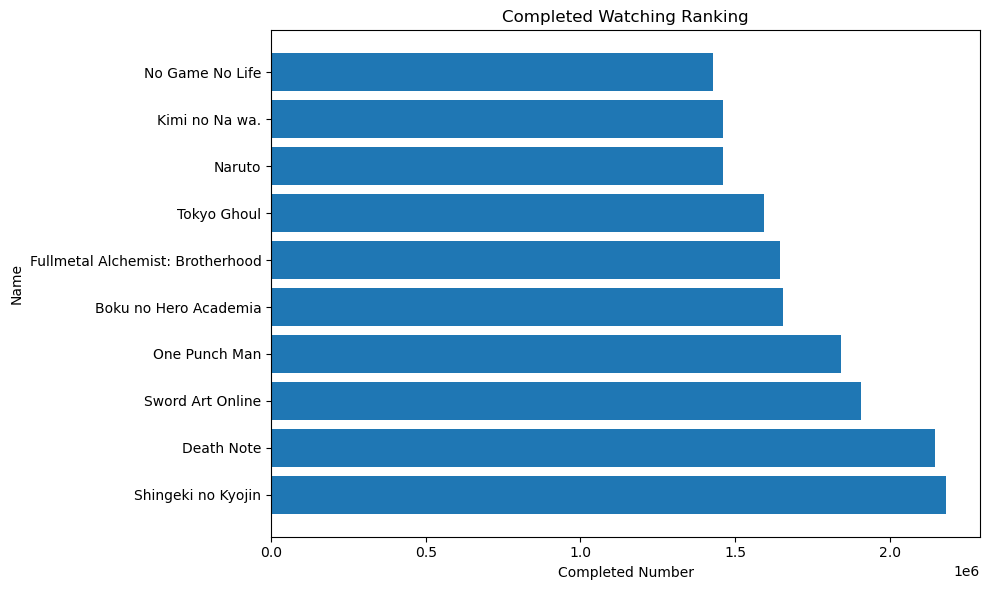

In [55]:
df_copy = df_copy.sort_values(by='Completed', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(df_copy['Name'], df_copy['Completed'])

plt.title('Completed Watching Ranking')
plt.xlabel('Completed Number')
plt.ylabel('Name')
plt.tight_layout()
plt.show()

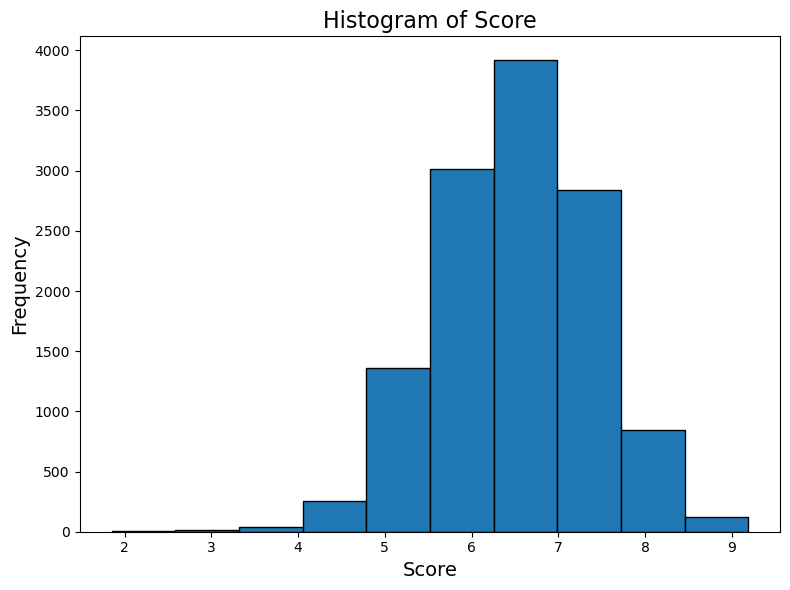

In [64]:
df_copy = df_copy[df_copy['Score'] != 0]

plt.figure(figsize=(8, 6))
plt.hist(df_copy['Score'], bins=10, edgecolor='black')

plt.title('Histogram of Score', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

## Recommendation System: Content-based Filtering

uses the attributes or features of an item  (this is the content part) to recommend other items similar to the user’s preferences. This approach is based on similarity of item and user features,  given information about a user and items they have interacted with (e.g. a user’s age, the category of a restaurant’s cuisine, the average review for a movie),  model the likelihood of a new interaction. 

[Reference](https://www.nvidia.com/en-us/glossary/recommendation-system/)

The similarity score will be calculated into 3 parts, and combine all them together with different weight.

- Genres: Calculating the similarity using cosine similarity from genre vectors.
- Synopsis: Calculating text similarity using TF-IDF
- Attributes: Calculating from vectors composed of Studio, Rating, Type. The matching attribute will contribute the point to this part.

### Genres

In [12]:
unique_genres = set(', '.join(anime_df['Genres']).split(', '))
unique_genres.discard('Unknown')
genre_columns = sorted(unique_genres)

print(f"There are total {len(genre_columns)} genres\n", genre_columns)

There are total 43 genres
 ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri']


In [13]:
genres_matrix = np.zeros(shape=(len(anime_df), len(genre_columns)), dtype=int)

genre_to_index = {genre: idx for idx, genre in enumerate(genre_columns)}

for i, row in anime_df.iterrows():
    genres = row['Genres'].split(', ')
    for genre in genres:
        if genre == 'Unknown':
            continue
        genres_matrix[i, genre_to_index[genre]] = 1

genres_df = pd.DataFrame(genres_matrix, columns=genre_columns, index=anime_df['MAL_ID'])
genres_df.head(10)

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
15,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
17,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
18,1,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
dot_product = np.dot(genres_matrix, genres_matrix.T)

norms = np.linalg.norm(genres_matrix, axis=1)
norms_matrix = np.outer(norms, norms)

norms_matrix[norms_matrix == 0] = 1
genre_similarity = dot_product / norms_matrix

genre_similarity_df = pd.DataFrame(genre_similarity, columns=anime_df['MAL_ID'], index=anime_df['MAL_ID'])
genre_similarity_df.head(10)

MAL_ID,1,5,6,7,8,15,16,17,18,19,...,48456,48466,48470,48471,48480,48481,48483,48488,48491,48492
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.730297,0.833333,0.333333,0.204124,0.408248,0.365148,0.204124,0.365148,0.154303,...,0.288675,0.288675,0.547723,0.471405,0.288675,0.235702,0.235702,0.000000,0.471405,0.288675
5,0.730297,1.000000,0.547723,0.547723,0.000000,0.223607,0.200000,0.000000,0.400000,0.338062,...,0.000000,0.316228,0.400000,0.516398,0.000000,0.258199,0.000000,0.182574,0.000000,0.316228
6,0.833333,0.547723,1.000000,0.333333,0.408248,0.612372,0.365148,0.408248,0.365148,0.154303,...,0.288675,0.288675,0.547723,0.235702,0.288675,0.235702,0.235702,0.000000,0.471405,0.288675
7,0.333333,0.547723,0.333333,1.000000,0.204124,0.204124,0.182574,0.000000,0.365148,0.462910,...,0.000000,0.288675,0.547723,0.000000,0.000000,0.471405,0.235702,0.333333,0.000000,0.288675
8,0.204124,0.000000,0.408248,0.204124,1.000000,0.250000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.447214,0.000000,0.707107,0.577350,0.288675,0.204124,0.288675,0.353553
15,0.408248,0.223607,0.612372,0.204124,0.250000,1.000000,0.223607,0.750000,0.447214,0.000000,...,0.707107,0.353553,0.223607,0.000000,0.000000,0.000000,0.288675,0.000000,0.288675,0.353553
16,0.365148,0.200000,0.365148,0.182574,0.000000,0.223607,1.000000,0.447214,0.200000,0.169031,...,0.316228,0.000000,0.200000,0.000000,0.000000,0.000000,0.258199,0.000000,0.516398,0.000000
17,0.204124,0.000000,0.408248,0.000000,0.250000,0.750000,0.447214,1.000000,0.223607,0.000000,...,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.288675,0.000000,0.577350,0.000000
18,0.365148,0.400000,0.365148,0.365148,0.000000,0.447214,0.200000,0.223607,1.000000,0.338062,...,0.316228,0.316228,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316228


In [15]:
def search_top_similarity(anime, n=5, similarities=genre_similarity):
    
    if type(anime) != int and type(anime) != str:
        print("The value should contain anime's name or ID")
        return None

    try:
        top_similarities = []
        aId = None
        if type(anime) == int:
            if anime in anime_df['MAL_ID']:
                aId = anime_df.index[anime_df['MAL_ID'] == anime]
            else:
                print("No existing ID in this dataset")
                return None
        elif type(anime) == str:
            if anime in anime_df['Name']:
                aId = anime_df.index[anime_df['Name'] == anime]
            else:
                print("No existing name in this dataset")
                return None
        
        top_similarities = np.argsort(similarities[aId])[0][-(n+1):-1]
        return top_similarities
    
    except:
        print("Error")

In [35]:
anime_id = 3229

top_s = search_top_similarity(anime_id, n=10)

if top_s is not None:
    df_top = anime_df["Name"].loc[top_s]
    print("I have watched {}, and it recommends".format(anime_df[anime_df['MAL_ID']==anime_id]['Name'].values))
    for top in df_top: print("\t-",top)

I have watched ['Kimi ga Aruji de Shitsuji ga Ore de'], and it recommends
	- Saenai Heroine no Sodatekata: Ai to Seishun no Service-kai
	- Akaneiro ni Somaru Saka: Hardcore
	- Hanaukyou Maid-tai: La Verite
	- Oniichan no Koto nanka Zenzen Suki ja Nai n da kara ne!!
	- Love♥Love? Specials
	- Hanaukyou Maid-tai
	- Hanaukyou Maid-tai OVA
	- Love Hina Final Selection
	- Love♥Love?
	- R-15: R15 Shounen Hyouryuuki


In [34]:
anime_id = 456

top_s = search_top_similarity(anime_id, n=10)

if top_s is not None:
    df_top = anime_df["Name"].loc[top_s]
    print("I have watched {}, and it recommends".format(anime_df[anime_df['MAL_ID']==anime_id]['Name'].values))
    for top in df_top: print("\t-",top)

I have watched ['Gokujou Seitokai'], and it recommends
	- Azumanga Web Daioh
	- Gokujou Seitokai
	- Hidamari Sketch Recap
	- Musashino!
	- Hidamari Sketch x 365 Recap
	- Minami-ke
	- Yuyushiki: Komarasetari, Komarasaretari
	- Wakaba*Girl
	- Minami-ke Tadaima
	- Urashimasakatasen no Nichijou


### Attributes

### Synopsis

## Recommendation System: Collaborative filtering

recommend items (this is the filtering part) based on preference information from many users (this is the collaborative part). This approach uses similarity of user preference behavior,  given previous interactions between users and items, recommender algorithms learn to predict future interaction.

[Reference](https://www.nvidia.com/en-us/glossary/recommendation-system/)